# Image Preperation, CNNs Image Classifier in Keras, Pre-Deployment

In [3]:
import numpy as np
import keras
from keras import backend as K
from keras.models import Sequential, load_model
from keras.layers import Activation
from keras.layers.core import Dense, Flatten
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import *
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

# More guidance:https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html

In [4]:
"""
CREATE VARIABLES WHICH CONTAIN THE PATHS TO THE TRAIN,TEST AND VALIDATE FOLDERS 
- You can give relative or absolute paths
"""

train_path = 'C:/Users/Darshil/gitly/Deep-Learning/My Projects/CNN_Keras/train'
valid_path = 'C:/Users/Darshil/gitly/Deep-Learning/My Projects/CNN_Keras/valid'
test_path = 'C:/Users/Darshil/gitly/Deep-Learning/My Projects/CNN_Keras/test'


"""
USING IMAGE DATA GENERATOR
- Important to understand that what this does is simply go into our directory and go into the class image folders we've created, 
and then simply find those images
Ex: if train/dog has 20 images it will recognize those images and label them as 'dog' I think

"""
train_batches = ImageDataGenerator().flow_from_directory(train_path, target_size=(224,224), classes = ['dog', 'cat'], batch_size = 10)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path, target_size=(224,224), classes = ['dog', 'cat'], batch_size = 4)
test_batches = ImageDataGenerator().flow_from_directory(test_path, target_size=(224,224), classes = ['dog', 'cat'], batch_size = 20)

Found 80 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


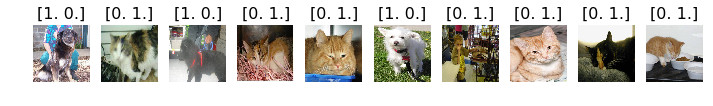

In [5]:
# Lets plot our images - copies this from image

def plots(ims, figsize= (12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize = figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)// rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows,cols,i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation = None if interp else 'none')

"""
using next(batch) uses the ImageDataGenerator object
"""        
imgs, labels = next(train_batches)
plots(imgs, titles = labels)

# Building and Training Our CNN Model

In [6]:
# Creating our model
model = Sequential([
    Conv2D(32,(3,3), activation = 'relu', input_shape = (224,224,3)), # Con2D- you mention the number of filters and the sizes
    Flatten(),
    Dense(2, activation = 'softmax')
])

model.compile(Adam(lr=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

# different than model.fit for fully connected NN
"""
PARAMETERS FOR model.fit_generator
- train_batches : we've created this variable up top where from the training directory, 
it takes x batches of dog and cats and loads it up

- steps_per_epochs: number of training examples / batch_size

- vlaidation_data = specific the validation data from the variable created above

- validation steps: validation examples / batch size 
"""
model.fit_generator(train_batches, steps_per_epoch = 8, validation_data= valid_batches, validation_steps = 10, epochs=5,verbose=2)

Epoch 1/5


KeyboardInterrupt: 

# Predicting Using Our CNN Model

In [ ]:
# Lets view our test data
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles = test_labels)

In [ ]:
# Reindexing
test_labels = test_labels[:,0]
test_labels

"""
PREDICT
- Remember that we use predict_generator here instead of simply model.predict. 
- we pass test_batches through 
- 1 step because each batch passes 10 and we pass 10 at a time
"""
# predict
predictions = model.predict_generator(test_batches, steps=2, verbose=0)
predictions.shape

In [ ]:
"""
Creating the confusion matrix!
"""

cm = confusion_matrix(test_labels, predictions[:,0])

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, Interpolation = 'nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print ('normalized confusion matrix')
        
    else:
        print ('Confusion matrix, without normalization')        
    print (cm)
    
    thresh = cm.max() / 2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment = 'center',
                color = 'white' if cm[i,j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm,cm_plot_labels,title='Confusion Matrix')

"""
INTERPRET 
- Here we see that our model with a 50% accuracy rate classifies images 20 images as as cats when they're dogs
- And specific all 20 images as cats and they are cats

Obviously its a very simple model and wouldn't work well this is just to learn. We need to import an existing pre-trained 
model and go from there
"""


# Fine Tuning the VGG16 Model

In [7]:
"""
KERAS.APPLICATIONS
- Keras has a repo of pretrained models that you can simply pull from to further your training or use it however you want
"""

vgg16_model = keras.applications.vgg16.VGG16()

# Lets check out the pre-trained model we're going to tune!
vgg16_model.summary()

"""
SUMMARY NOTES
- This architecture is huge and hasover 138K parameters!
- The last layer has 1000 nodes for 1000 classes but we only need 2 so we add own 2 
- The VGG_16 model has 1000 classes and several classes belonging to certain breed of cats and dogs. We want to further limit
to only cat or dog hence we can replace the last layer and train

"""

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

'\nSUMMARY NOTES\n- This architecture is huge and hasover 138K parameters!\n- The last layer has 1000 nodes for 1000 classes but we only need 2 so we add own 2 \n- The VGG_16 model has 1000 classes and several classes belonging to certain breed of cats and dogs. We want to further limit\nto only cat or dog hence we can replace the last layer and train\n\n'

In [8]:
# This model type is not" Sequential" its just "Model", lets transform it to Sequential
type(vgg16_model)

# Transform here
model = Sequential()

"""
What we'll do here is the following
- create an empty sequential model
- then iterate over the vGG model and simply add that to our empty model, thus creating a clone of that architecture
""" 
# NOTES - You can access layers using ".layers"
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
# You can remove the last added layer in a Sequential model by calling .pop() but it doesn't work so

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [10]:
# Next we want to iterate over all layers in OUR model
"""
layer.trainable
- Here it is important to note that we want to freeze our layers so weights will never be updated except in the last layer..
which we will train in the next step
- You can fine tune however you want FYI
"""
for layer in model.layers:
    layer.trainable = False

In [11]:
#lastly we add our 2 custom labels
model.add(Dense(2,activation = 'softmax'))

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [13]:
"""
TUNING AND TRAINING A PRETRAINED MODEL
- We use model.compile to train the last layer ONLY
- So what happens is the weights of the last layer get initialized and then optimized during training
"""
model.compile(Adam(lr=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit_generator(train_batches, steps_per_epoch = 8, validation_data= valid_batches, validation_steps = 10, epochs=5,verbose=2)

Epoch 1/5
 - 78s - loss: 0.7321 - acc: 0.7250 - val_loss: 0.1652 - val_acc: 0.9250
Epoch 2/5
 - 75s - loss: 0.1447 - acc: 0.9250 - val_loss: 0.1051 - val_acc: 0.9500
Epoch 3/5
 - 82s - loss: 0.0297 - acc: 0.9875 - val_loss: 0.0792 - val_acc: 0.9750
Epoch 4/5
 - 76s - loss: 0.0079 - acc: 1.0000 - val_loss: 0.0921 - val_acc: 0.9500
Epoch 5/5
 - 78s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.0970 - val_acc: 0.9500


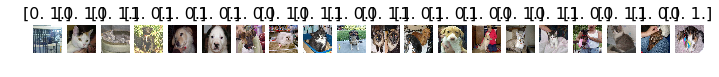

In [14]:
"""
Now we can use this newly trained pre-trained model and test it out!
- We copy the test code from up above
"""
# Lets view our test data
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles = test_labels)

# Reindexing
test_labels = test_labels[:,0]
test_labels

"""
PREDICT
- Remember that we use predict_generator here instead of simply model.predict. 
- we pass test_batches through 
- 1 step because each batch passes 10 and we pass 10 at a time
"""
# predict
predictions = model.predict_generator(test_batches, steps=1, verbose=0)

In [15]:
'predictions',np.around(predictions[:,0]),'Test Labels' ,test_labels

('predictions',
 array([1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,
        0., 0., 0.], dtype=float32),
 'Test Labels',
 array([0., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1.,
        0., 1., 0.], dtype=float32))

Confusion matrix, without normalization
[[9 1]
 [2 8]]


'\nGREAT IMPROVEMENT\n- we can still change a lot of other parameters to get this to be even better\n'

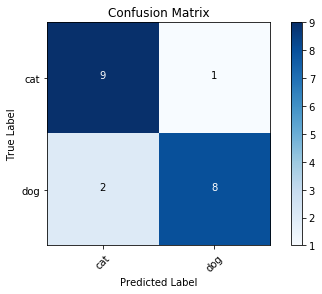

In [16]:
cm = confusion_matrix(test_labels,np.round(predictions[:,0]))
cm_plot_labels = ['cat', 'dog']

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, Interpolation = 'nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
        print ('normalized confusion matrix')
        
    else:
        print ('Confusion matrix, without normalization')        
    print (cm)
    
    thresh = cm.max() / 2
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,cm[i,j], horizontalalignment = 'center',
                color = 'white' if cm[i,j] > thresh else 'black')
        
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
cm_plot_labels = ['cat', 'dog']
plot_confusion_matrix(cm,cm_plot_labels,title = 'Confusion Matrix')

"""
GREAT IMPROVEMENT
- we can still change a lot of other parameters to get this to be even better
"""

In [17]:
"""
PREDICTING ON A SINGLE IMAGE
"""

from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image

# Predicting on a single image

img_path = 'C:/Users/Darshil/Desktop/Dreams/doge.jpg'
img = image.load_img(img_path, target_size=(224,224))
x = image.img_to_array(img)
x = np.expand_dims(x,axis=0)
x = preprocess_input(x)

p =model.predict(x)
pr = np.around(p[:,0])
print (img)
print (pr)

<PIL.Image.Image image mode=RGB size=224x224 at 0x20E8F7D5BE0>
[1.]


In [18]:
model.save('C:/Users/Darshil/gitly/Deep-Learning/My Projects/Flask_Keras/vgg_16.h5')
del model

In [19]:
old_model = load_model('C:/Users/Darshil/gitly/Deep-Learning/My Projects/Flask_Keras/vgg_16.h5')
old_model.summary()

ValueError: You are trying to load a weight file containing 16 layers into a model with 0 layers.

In [ ]:
model.summary()

vgg16_model = keras.applications.vgg16.VGG16()
type(vgg16_model)
model = Sequential()

for layer in vgg16_model.layers[:-1]:
    model.add(layer)
model.add(Dense(2,activation = 'softmax'))
model.compile(Adam(lr=0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.fit_generator(train_batches, steps_per_epoch = 8, validation_data= valid_batches, validation_steps = 10, 
                    epochs=5,verbose=2)
model.save('C:/Users/Darshil/gitly/Deep-Learning/My Projects/Flask_Keras/vgg_16.h5')
old_model = load_model('C:/Users/Darshil/gitly/Deep-Learning/My Projects/Flask_Keras/vgg_16.h5')